In [1]:
from matplotlib import pyplot as plt
from matplotlib.dates import MonthLocator, num2date
from matplotlib.ticker import FuncFormatter
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot

import pandas as pd
import numpy as np
import datetime as dt
from collections import defaultdict
import time
import datetime as dt
from pytz import timezone
tz = timezone('EST')
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
sns.set()

In [2]:
import json
from prophet.serialize import model_to_json, model_from_json

with open('nyc_solar_model.json', 'r') as fin:
    m = model_from_json(json.load(fin))  # Load model

In [3]:
future_pd = m.make_future_dataframe(
        periods=3650,
        freq='D',
        include_history=False
    )
    
# make predictions
forecast_pd = m.predict(future_pd)

In [4]:
forecast_pd

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-12-20 22:00:00,168.871173,-219.627953,301.785406,168.871173,168.871173,-0.316755,-0.316755,-0.316755,-0.784910,...,0.004494,0.004494,0.004494,-0.472649,-0.472649,-0.472649,0.0,0.0,0.0,36.322582
1,2019-12-21 22:00:00,168.919699,-182.504614,287.553465,168.919699,168.919699,-0.316755,-0.316755,-0.316755,-0.742854,...,0.038880,0.038880,0.038880,-0.464979,-0.464979,-0.464979,0.0,0.0,0.0,43.437105
2,2019-12-22 22:00:00,168.968224,-216.292454,288.476142,168.968224,168.968224,-0.316755,-0.316755,-0.316755,-0.754827,...,0.018647,0.018647,0.018647,-0.456720,-0.456720,-0.456720,0.0,0.0,0.0,41.426384
3,2019-12-23 22:00:00,169.016749,-207.222213,267.185631,169.016749,169.016749,-0.316755,-0.316755,-0.316755,-0.777222,...,-0.012438,-0.012438,-0.012438,-0.448029,-0.448029,-0.448029,0.0,0.0,0.0,37.653268
4,2019-12-24 22:00:00,169.065275,-210.239284,296.905915,169.065275,169.065275,-0.316755,-0.316755,-0.316755,-0.793929,...,-0.038111,-0.038111,-0.038111,-0.439062,-0.439062,-0.439062,0.0,0.0,0.0,34.839459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3645,2029-12-12 22:00:00,345.746403,-6880.312496,6232.792231,-36760.111199,33707.176596,-0.316755,-0.316755,-0.316755,-0.815017,...,-0.000325,-0.000325,-0.000325,-0.497937,-0.497937,-0.497937,0.0,0.0,0.0,63.957318
3646,2029-12-13 22:00:00,345.794928,-6400.601102,5791.806427,-36773.706994,33717.718475,-0.316755,-0.316755,-0.316755,-0.826577,...,-0.011148,-0.011148,-0.011148,-0.498674,-0.498674,-0.498674,0.0,0.0,0.0,59.968803
3647,2029-12-14 22:00:00,345.843453,-7018.453561,6455.259282,-36787.302789,33728.260354,-0.316755,-0.316755,-0.316755,-0.810280,...,0.004494,0.004494,0.004494,-0.498020,-0.498020,-0.498020,0.0,0.0,0.0,65.613255
3648,2029-12-15 22:00:00,345.891979,-8356.202802,7547.579556,-36800.898583,33738.802233,-0.316755,-0.316755,-0.316755,-0.773894,...,0.038880,0.038880,0.038880,-0.496019,-0.496019,-0.496019,0.0,0.0,0.0,78.208418


In [5]:
forecast_pd[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3645,2029-12-12 22:00:00,63.957318,-6880.312496,6232.792231
3646,2029-12-13 22:00:00,59.968803,-6400.601102,5791.806427
3647,2029-12-14 22:00:00,65.613255,-7018.453561,6455.259282
3648,2029-12-15 22:00:00,78.208418,-8356.202802,7547.579556
3649,2029-12-16 22:00:00,72.354886,-7734.095034,7151.463112


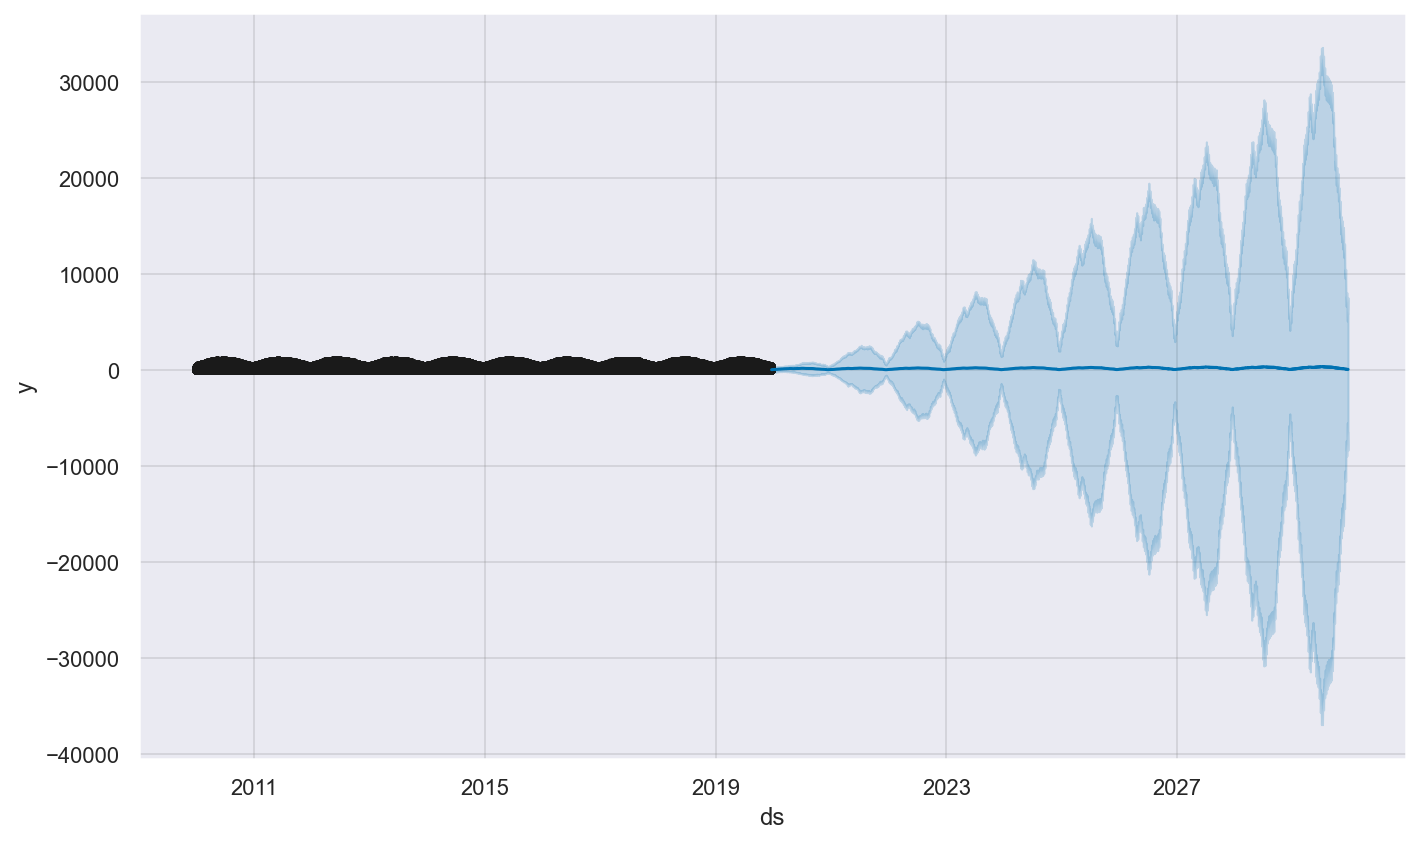

In [6]:
fig1 = m.plot(forecast_pd)

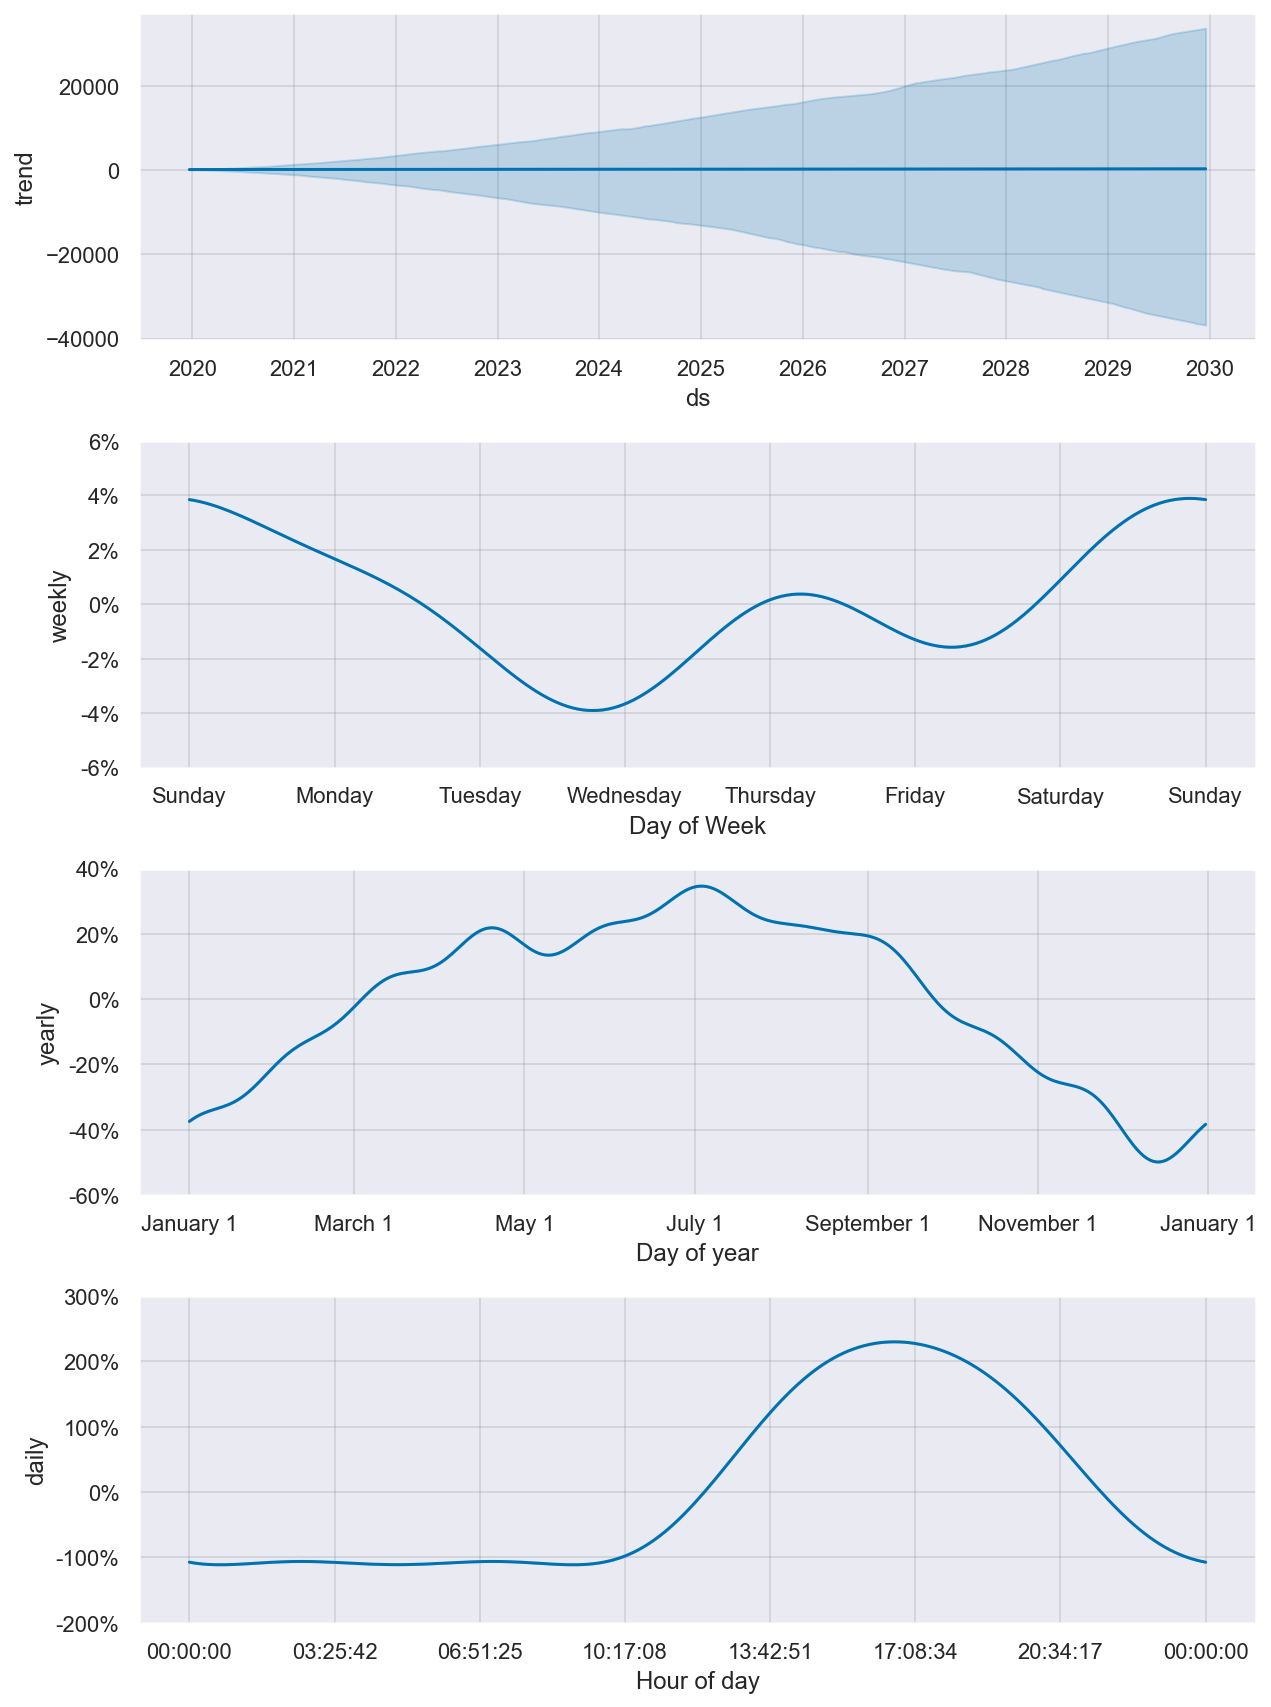

In [7]:
fig2 = m.plot_components(forecast_pd)

In [8]:
forecast_pd.to_csv('nyc_solar_forecast.csv', index=False)